In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load training data
train = pd.read_csv('train.csv')

# Drop high-cardinality or unhelpful columns
cols_to_drop = ['id', 'Episode_Title']  # High cardinality / text
train = train.drop(columns=cols_to_drop)

# Drop rows with missing values for simplicity (we can impute later)
train = train.dropna()

# Sample 10% to make the linear model faster to train and easier to inspect
train_sample = train.sample(frac=0.1, random_state=42)

# Target column
y = train_sample['Listening_Time_minutes']

# Drop target from features
X = train_sample.drop(columns=['Listening_Time_minutes'])

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize model
rf = RandomForestRegressor(
    n_estimators=100,       # number of trees
    max_depth=None,         # trees can grow deep
    random_state=42,
    n_jobs=-1               # use all cores for faster training
)

# Fit the model
rf.fit(X_encoded, y)

# Predict on training data
y_pred_rf = rf.predict(X_encoded)

# Evaluate
rmse_rf = mean_squared_error(y, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y, y_pred_rf)
r2_rf = r2_score(y, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest R²: {r2_rf:.4f}")


X shape: (53905, 71)
Random Forest RMSE: 3.96
Random Forest MAE: 2.98
Random Forest R²: 0.9788


C:\Users\james\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Interpretation

RMSE + MAE drop significantly → model is much more accurate

R² ~ 0.98 → your model now explains almost all the variation in Listening_Time_minutes

This is a clear sign of strong nonlinear + interaction effects — Random Forest captured what linear regression could not

Note: We used X_encoded here as Random Forest in sklearn does require numeric input

## Plot Residuals

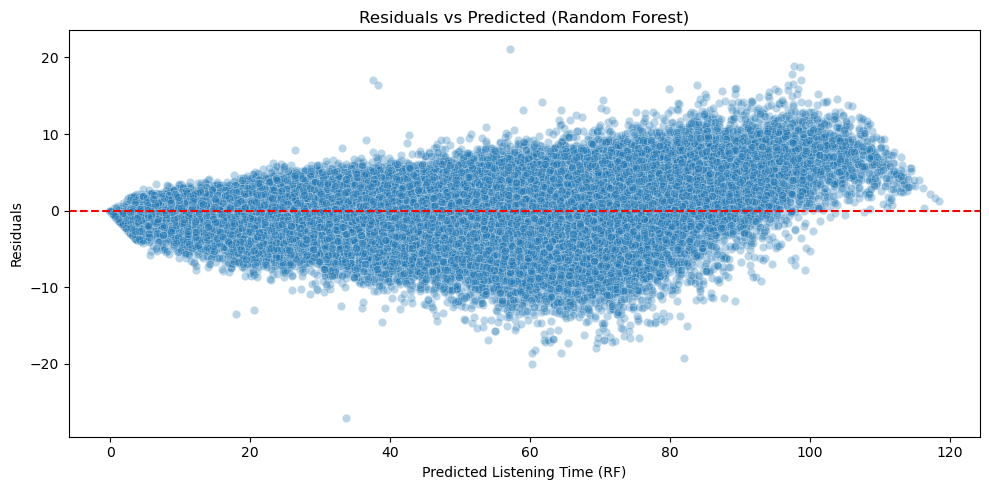

In [7]:
residuals_rf = y - y_pred_rf

plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred_rf, y=residuals_rf, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Listening Time (RF)')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Random Forest)')
plt.tight_layout()
plt.show()

## Feature Importance

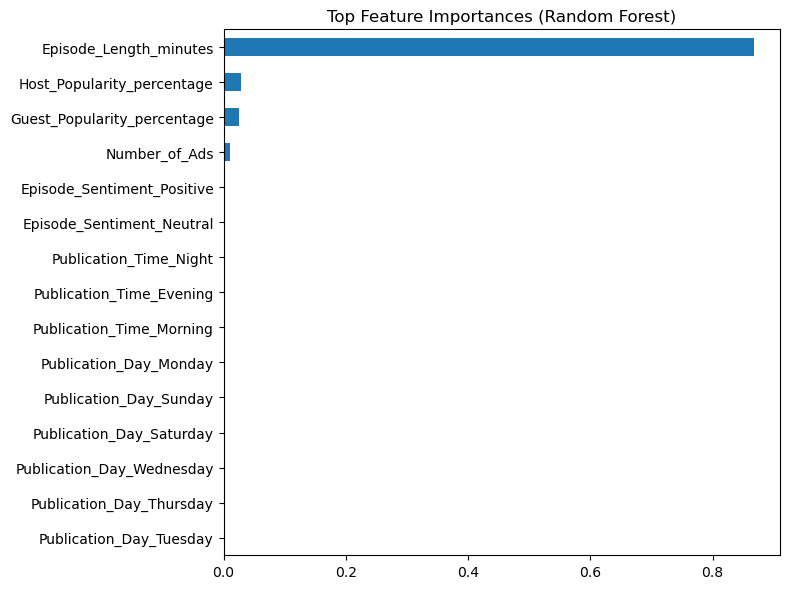

In [10]:
importances = pd.Series(rf.feature_importances_, index=X_encoded.columns)
top_importances = importances.sort_values(ascending=False).head(15)

top_importances.plot(kind='barh', figsize=(8, 6), title='Top Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


###  Random Forest Model Summary

A Random Forest Regressor was trained on the same encoded feature set to capture nonlinearities and feature interactions missed by the linear model.

####  Performance (on training data)
- RMSE: 3.96
- MAE: 2.98
- R²: 0.9788

The Random Forest significantly outperformed the linear regression model, reducing error by over 60%. The R² score of ~0.98 indicates the model explained nearly all variance in listening time.

####  Residual Analysis
The residuals were tightly clustered around zero, confirming improved model fit. However, a subtle upward trend was observed in residuals as predicted listening time increased, suggesting the model slightly underpredicts for longer episodes. This pattern may warrant further attention or transformation of the target variable (e.g., log-scale) in future models.

####  Feature Importance
- `Episode_Length_minutes` was by far the most influential feature, dominating the model's decisions
- Popularity metrics (host/guest) and number of ads had minor importance
- Categorical features such as sentiment, genre, and publication time/day had minimal impact, indicating potential for interaction terms or more advanced models (e.g., gradient boosting) to better leverage them

####  Summary
The Random Forest model provides strong predictive performance and reveals that most of the signal in listening time is driven by episode length. To improve further, it may be beneficial to:
- Explore new engineered features
- Model interactions explicitly
- Try a more powerful model like LightGBM

Next, a gradient boosting model will be explored for better generalization and possibly improved use of weak signals.
